# Notebook 7 — Risk Management & Model Validation

Production pricing engines require a robust **risk** and **validation** layer. This notebook covers:

1. **Numerical Greeks** — bump-and-reprice with any pricer
2. **Scenario analysis** — 2D spot × vol heatmaps
3. **Portfolio risk aggregation** — net Greeks across multiple positions
4. **VaR and CVaR** — historical risk measures
5. **Cross-model validation** — BS vs MC vs Tree vs FDM vs FEM
6. **Convergence analysis** — error decay and order estimation
7. **Stress testing** — 3D (spot × vol × rate) shock grid
8. **Delta-hedge backtesting** — P&L distribution from hedging simulation

These tools form the core toolkit of a **model validation quant** (SR 11-7 style independent review).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

import optpricer as op
from optpricer.risk import (
    numerical_greeks, scenario_grid, portfolio_risk,
    var_historical, cvar_historical,
)
from optpricer.validation import (
    cross_validate, convergence_analysis, stress_test, backtest_delta_hedge,
)
from optpricer.processes import gbm_paths

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

## 1. Numerical Greeks via Bump-and-Reprice

The `numerical_greeks` function computes $\Delta$, $\Gamma$, $\mathcal{V}$ (vega), $\Theta$, and $\rho$ via **central finite differences** on any pricer callable. This is model-agnostic — the same function works whether the pricer is BS, FDM, MC, or any custom model.

We compare the numerical Greeks against the analytical BS values.

In [2]:
opt = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.0)

# Define a pricer callable with the right signature
def bs_pricer(S, K, T, r, q, sigma, kind):
    o = op.OptionSpec(S0=S, K=K, T=T, r=r, sigma=sigma, q=q)
    return op.bs_price(o, kind)

num_g = numerical_greeks(bs_pricer, 100, 100, 1.0, 0.05, 0.0, 0.20, op.CALL)
ana_g = op.bs_greeks(opt, op.CALL)

print(f"{'Greek':<8} {'Analytical':>12} {'Numerical':>12} {'|Err|':>12}")
print("-" * 46)
for greek in ["delta", "gamma", "vega", "theta", "rho"]:
    a = ana_g[greek]
    n = num_g[greek]
    print(f"{greek:<8} {a:>12.6f} {n:>12.6f} {abs(a-n):>12.6f}")

Greek      Analytical    Numerical        |Err|
----------------------------------------------
delta        0.636831     0.636745     0.000086
gamma        0.018762     0.018760     0.000002
vega        37.524035    37.523913     0.000122
theta       -6.414028    -6.416906     0.002878
rho         53.232482    53.224772     0.007710


The bump-and-reprice Greeks match the analytical values to high precision. The small discrepancies are due to the finite bump size (1% by default).

## 2. Scenario Analysis — Spot × Vol Heatmap

A **scenario grid** evaluates the option price across a 2D grid of spot shocks and vol shocks. This is a standard risk-management visualisation for understanding how P&L changes under joint market moves.

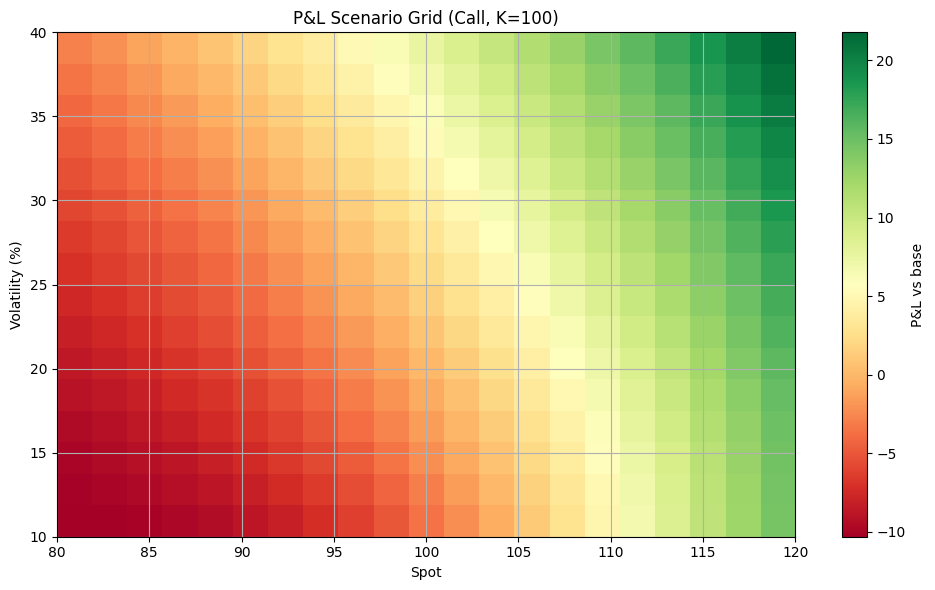

In [3]:
spot_range = np.linspace(80, 120, 21)
vol_range = np.linspace(0.10, 0.40, 16)

grid = scenario_grid(bs_pricer, 100, 100, 1.0, 0.05, 0.0, 0.20, op.CALL,
                     spot_range, vol_range)

# Compute P&L relative to base case
base_price = bs_pricer(100, 100, 1.0, 0.05, 0.0, 0.20, op.CALL)
pnl = grid["prices"] - base_price

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(pnl.T, origin="lower", aspect="auto",
               extent=[spot_range.min(), spot_range.max(),
                       vol_range.min() * 100, vol_range.max() * 100],
               cmap="RdYlGn")
ax.set_xlabel("Spot")
ax.set_ylabel("Volatility (%)")
ax.set_title("P&L Scenario Grid (Call, K=100)")
fig.colorbar(im, ax=ax, label="P&L vs base")
plt.tight_layout()
plt.show()

The heatmap shows that a long call benefits from higher spot (positive delta) and higher vol (positive vega). The top-right corner is the best scenario; bottom-left is the worst.

## 3. Portfolio Risk Aggregation

The `portfolio_risk` function computes position-weighted Greeks for a book of options. Here we construct a simple portfolio: long a call spread, short a put.

In [4]:
portfolio = [
    {"S": 100, "K": 95,  "T": 0.5, "r": 0.05, "q": 0.0, "sigma": 0.20,
     "kind": op.CALL, "position": +10},   # Long 10 ITM calls
    {"S": 100, "K": 110, "T": 0.5, "r": 0.05, "q": 0.0, "sigma": 0.20,
     "kind": op.CALL, "position": -10},   # Short 10 OTM calls
    {"S": 100, "K": 100, "T": 0.25, "r": 0.05, "q": 0.0, "sigma": 0.25,
     "kind": op.PUT, "position": -5},     # Short 5 ATM puts
]

risk = portfolio_risk(portfolio, bs_pricer)

print("Portfolio Risk Summary")
print("=" * 35)
print(f"Total Value:  {risk['total_value']:>10.2f}")
print(f"Total Delta:  {risk['total_delta']:>10.4f}")
print(f"Total Gamma:  {risk['total_gamma']:>10.4f}")
print(f"Total Vega:   {risk['total_vega']:>10.4f}")
print(f"Total Theta:  {risk['total_theta']:>10.4f}")
print(f"Total Rho:    {risk['total_rho']:>10.4f}")

print("\nPer-Instrument Breakdown:")
for i, (inst, g) in enumerate(zip(portfolio, risk['instrument_greeks'])):
    print(f"  [{i}] {inst['kind']} K={inst['K']} pos={inst['position']:+d}: "
          f"delta={g['delta']:+.3f}, gamma={g['gamma']:+.4f}, price={g['price']:+.2f}")

Portfolio Risk Summary
Total Value:       47.88
Total Delta:      6.1174
Total Gamma:     -0.1807
Total Vega:    -121.8247
Total Theta:     25.7826
Total Rho:      222.1325

Per-Instrument Breakdown:
  [0] call K=95 pos=+10: delta=+7.289, gamma=+0.2341, price=+98.73
  [1] call K=110 pos=-10: delta=-3.350, gamma=-0.2575, price=-29.06
  [2] put K=100 pos=-5: delta=+2.178, gamma=-0.1574, price=-21.78


## 4. VaR and CVaR

**Value-at-Risk (VaR)** answers: "What is the worst loss at the $p$-th percentile over a given horizon?"

**Conditional VaR (CVaR)** — also called *Expected Shortfall* — answers: "What is the average loss in the worst $1-p$ percent of scenarios?"

CVaR is always $\geq$ VaR and is considered a more coherent risk measure.

99% VaR  = 2.9824%    CVaR = 3.3754%
95% VaR  = 2.1641%    CVaR = 2.6929%


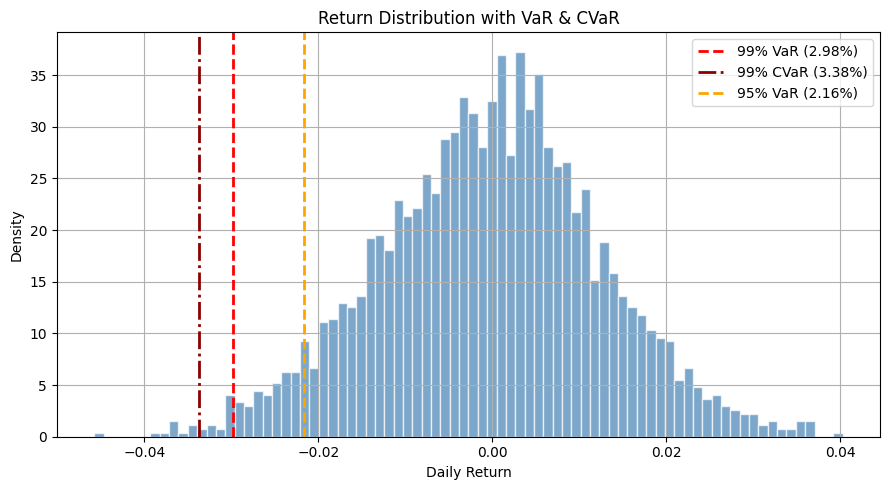

In [5]:
# Simulate daily returns from GBM
rng = np.random.default_rng(42)
mu_daily = 0.05 / 252
sigma_daily = 0.20 / np.sqrt(252)
returns = rng.normal(mu_daily, sigma_daily, size=2520)  # ~10 years of daily returns

var_99 = var_historical(returns, confidence=0.99)
cvar_99 = cvar_historical(returns, confidence=0.99)
var_95 = var_historical(returns, confidence=0.95)
cvar_95 = cvar_historical(returns, confidence=0.95)

print(f"99% VaR  = {var_99:.4%}    CVaR = {cvar_99:.4%}")
print(f"95% VaR  = {var_95:.4%}    CVaR = {cvar_95:.4%}")

# Visualise
fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(returns, bins=80, density=True, alpha=0.7, color="steelblue", edgecolor="white")
ax.axvline(-var_99, color="red", linestyle="--", linewidth=2, label=f"99% VaR ({var_99:.2%})")
ax.axvline(-cvar_99, color="darkred", linestyle="-.", linewidth=2, label=f"99% CVaR ({cvar_99:.2%})")
ax.axvline(-var_95, color="orange", linestyle="--", linewidth=2, label=f"95% VaR ({var_95:.2%})")
ax.set_xlabel("Daily Return")
ax.set_ylabel("Density")
ax.set_title("Return Distribution with VaR & CVaR")
ax.legend()
plt.tight_layout()
plt.show()

---

## 5. Cross-Model Validation

A fundamental check: **all five pricing engines** (BS, MC, CRR Tree, FDM, FEM) should agree on the same European option. `cross_validate` runs all methods and reports the maximum discrepancy.

In [6]:
opt_cv = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.0)

results = cross_validate(opt_cv, op.CALL, mc_paths=500_000)

print(f"{'Method':<10} {'Price':>12}")
print("-" * 24)
for method in ["bs", "mc", "tree", "fdm", "fem"]:
    val = results[method]
    if isinstance(val, tuple):
        print(f"{method.upper():<10} {val[0]:>12.6f}  (SE: {val[1]:.6f})")
    else:
        print(f"{method.upper():<10} {val:>12.6f}")

print(f"\nMax discrepancy vs BS: {results['max_discrepancy']:.6f}")

Method            Price
------------------------
BS            10.450584
MC            10.451695  (SE: 0.005612)
TREE          10.446585
FDM           10.449147
FEM           10.450066

Max discrepancy vs BS: 0.003998


All five methods should agree to within a few cents. This cross-validation is a mandatory check before deploying any new pricer in production.

## 6. Convergence Analysis

We analyse how each numerical method converges to the analytical BS price as the resolution parameter increases. The `convergence_analysis` function sweeps the parameter (paths, steps, grid size) and estimates the **convergence order** from a log-log regression.

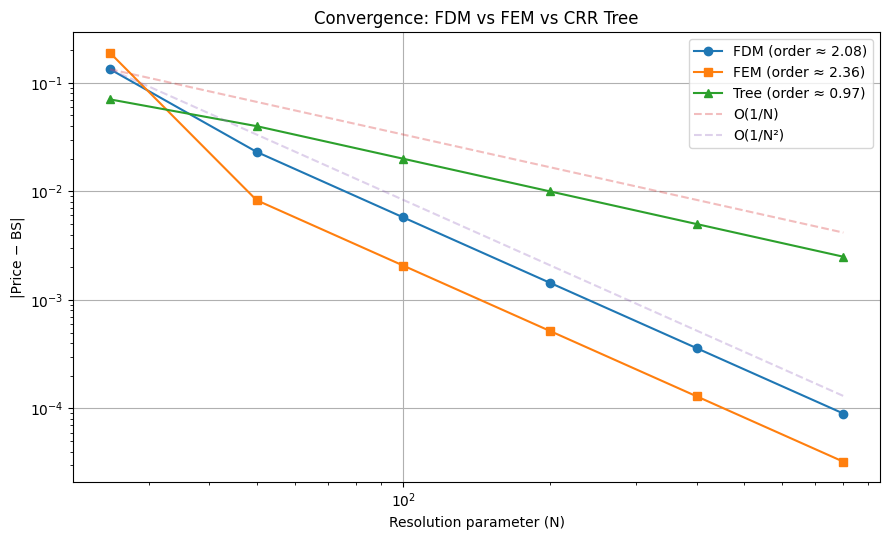

In [7]:
# FDM convergence
fdm_conv = convergence_analysis(
    opt_cv, op.CALL, "fdm", "N_S",
    [25, 50, 100, 200, 400, 800]
)

# FEM convergence
fem_conv = convergence_analysis(
    opt_cv, op.CALL, "fem", "N_S",
    [25, 50, 100, 200, 400, 800]
)

# Tree convergence
tree_conv = convergence_analysis(
    opt_cv, op.CALL, "tree", "N",
    [25, 50, 100, 200, 400, 800]
)

fig, ax = plt.subplots(figsize=(9, 5.5))
ax.loglog(fdm_conv["params"], fdm_conv["errors"], "o-",
          label=f"FDM (order ≈ {fdm_conv['order']:.2f})")
ax.loglog(fem_conv["params"], fem_conv["errors"], "s-",
          label=f"FEM (order ≈ {fem_conv['order']:.2f})")
ax.loglog(tree_conv["params"], tree_conv["errors"], "^-",
          label=f"Tree (order ≈ {tree_conv['order']:.2f})")

# Reference lines
N_ref = np.array(fdm_conv["params"])
ax.loglog(N_ref, fdm_conv["errors"][0] * (N_ref[0]/N_ref)**1,
          "--", alpha=0.3, label="O(1/N)")
ax.loglog(N_ref, fdm_conv["errors"][0] * (N_ref[0]/N_ref)**2,
          "--", alpha=0.3, label="O(1/N²)")

ax.set_xlabel("Resolution parameter (N)")
ax.set_ylabel("|Price − BS|")
ax.set_title("Convergence: FDM vs FEM vs CRR Tree")
ax.legend()
plt.tight_layout()
plt.show()

## 7. Stress Testing — 3D Shock Grid

The `stress_test` function evaluates option prices across a 3D grid of shocks: **spot** (multiplicative), **vol** (additive), and **rate** (additive). This reveals how the option value behaves under extreme but plausible market conditions.

Stress test output shape: (7, 5, 3)
  (spot × vol × rate) = (7 × 5 × 3)


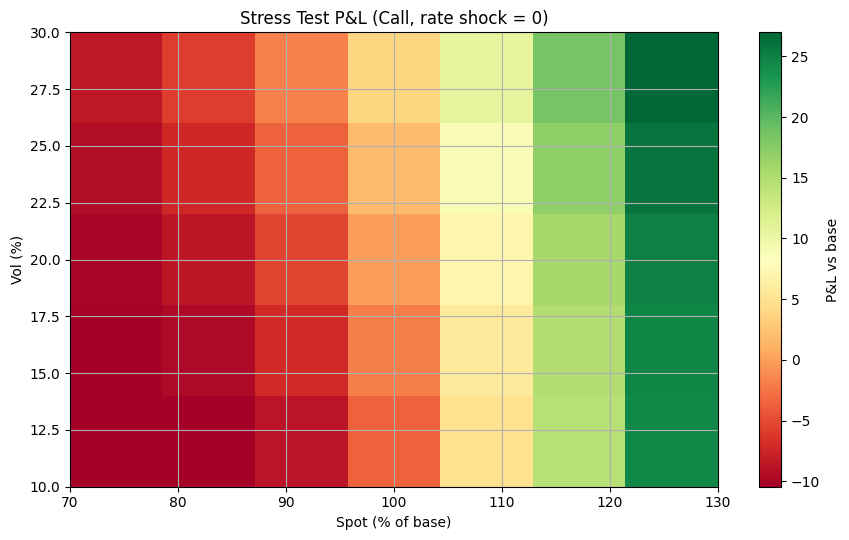

In [8]:
spot_shocks = np.array([0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
vol_shocks = np.array([-0.10, -0.05, 0.0, 0.05, 0.10])
rate_shocks = np.array([-0.02, 0.0, 0.02])

results_3d = stress_test(opt_cv, op.CALL, spot_shocks, vol_shocks, rate_shocks)

print(f"Stress test output shape: {results_3d.shape}")
print(f"  (spot × vol × rate) = ({len(spot_shocks)} × {len(vol_shocks)} × {len(rate_shocks)})")

# Visualise the spot × vol slice at base rate (rate_shocks[1] = 0)
slice_base_rate = results_3d[:, :, 1]  # rate shock = 0
base_val = results_3d[3, 2, 1]  # spot=1.0, vol=0.0, rate=0.0

fig, ax = plt.subplots(figsize=(9, 5.5))
im = ax.imshow((slice_base_rate - base_val).T, origin="lower", aspect="auto",
               extent=[spot_shocks.min()*100, spot_shocks.max()*100,
                       (0.20 + vol_shocks.min())*100, (0.20 + vol_shocks.max())*100],
               cmap="RdYlGn")
ax.set_xlabel("Spot (% of base)")
ax.set_ylabel("Vol (%)")
ax.set_title("Stress Test P&L (Call, rate shock = 0)")
fig.colorbar(im, ax=ax, label="P&L vs base")
plt.tight_layout()
plt.show()

## 8. Delta-Hedge Backtesting

The ultimate model validation: simulate delta-hedging a short option position along pre-generated GBM paths and check that the **hedging P&L** is centred near zero.

In a Black-Scholes world with continuous rebalancing, the P&L is exactly zero. With discrete rebalancing, we expect:
- Mean P&L $\approx 0$ (unbiased)
- Standard deviation proportional to $\sqrt{\Delta t}$ (hedging error from gamma)

Delta-Hedge Backtest Results (10,000 paths, daily rebalancing)
  Mean P&L:      0.0042
  Std P&L:       0.4451
  Worst path:   -3.2229


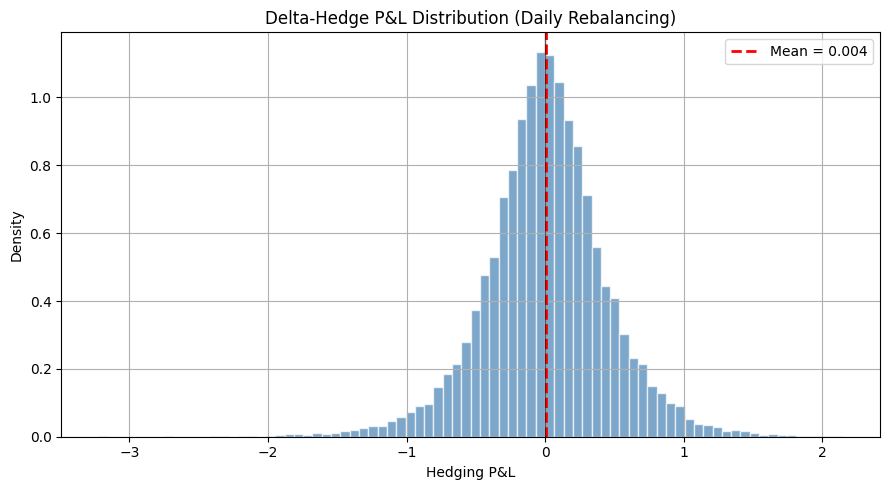

In [9]:
# Generate paths
paths = gbm_paths(S0=100, r=0.05, q=0.0, sigma=0.20,
                  T=1.0, n_steps=252, n_paths=10_000, seed=42)

# Backtest with daily rebalancing
bt = backtest_delta_hedge(opt_cv, op.CALL, paths, rebalance_freq=1)

print(f"Delta-Hedge Backtest Results (10,000 paths, daily rebalancing)")
print(f"  Mean P&L:    {bt['mean_pnl']:>8.4f}")
print(f"  Std P&L:     {bt['std_pnl']:>8.4f}")
print(f"  Worst path:  {bt['max_drawdown']:>8.4f}")

fig, ax = plt.subplots(figsize=(9, 5))
ax.hist(bt["pnl"], bins=80, density=True, alpha=0.7, color="steelblue", edgecolor="white")
ax.axvline(bt["mean_pnl"], color="red", linestyle="--", linewidth=2,
           label=f"Mean = {bt['mean_pnl']:.3f}")
ax.axvline(0, color="black", linestyle="-", linewidth=1, alpha=0.5)
ax.set_xlabel("Hedging P&L")
ax.set_ylabel("Density")
ax.set_title("Delta-Hedge P&L Distribution (Daily Rebalancing)")
ax.legend()
plt.tight_layout()
plt.show()

The P&L distribution should be approximately centred at zero, confirming that the BS delta hedge is unbiased under GBM dynamics. The spread reflects **gamma P&L** from discrete rebalancing — this is the residual risk that cannot be eliminated without continuous trading.

### Summary

This notebook demonstrated the full **risk and validation toolkit**:

| Tool | Purpose |
|---|---|
| `numerical_greeks` | Model-agnostic bump-and-reprice Greeks |
| `scenario_grid` | 2D spot × vol P&L heatmap |
| `portfolio_risk` | Net Greeks across a multi-leg book |
| `var_historical` / `cvar_historical` | Historical risk measures |
| `cross_validate` | Five-engine consistency check |
| `convergence_analysis` | Error decay and order estimation |
| `stress_test` | 3D shock grid |
| `backtest_delta_hedge` | Hedging P&L simulation |

Together these form the core of a production model-validation framework.